# Binomial Tree Pricing for Barrier Options

In this notebook, we implement pricing for barrier options using the binomial tree method. We will focus on path-dependent barrier types such as:
- **Up-and-Out Call**
- **Down-and-In Put**

The binomial model is extended by checking the barrier condition at each node and adjusting payoffs accordingly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def barrier_option_payoff(ST, K, option_type="call"):
    if option_type == "call":
        return np.maximum(ST - K, 0)
    else:
        return np.maximum(K - ST, 0)

In [3]:
def binomial_barrier_pricing(S0, K, T, r, sigma, N, barrier, option_type='call', barrier_type='up-and-out'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Asset price tree
    ST = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            ST[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Terminal payoffs
    payoff = np.zeros(N+1)
    for j in range(N+1):
        barrier_hit = False
        path = [S0 * (u ** (i - k)) * (d ** k) for i, k in zip(range(N), [j]*N)]

        if 'up' in barrier_type:
            barrier_hit = any(S > barrier for S in path)
        elif 'down' in barrier_type:
            barrier_hit = any(S < barrier for S in path)

        if 'out' in barrier_type:
            if barrier_hit:
                payoff[j] = 0
            else:
                payoff[j] = barrier_option_payoff(ST[j, N], K, option_type)
        elif 'in' in barrier_type:
            if barrier_hit:
                payoff[j] = barrier_option_payoff(ST[j, N], K, option_type)
            else:
                payoff[j] = 0

    # Backward induction
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            payoff[j] = np.exp(-r * dt) * (p * payoff[j] + (1 - p) * payoff[j+1])

    return payoff[0]

In [4]:
S0 = 100      # Initial stock price
K = 100       # Strike price
T = 1.0       # Time to maturity
r = 0.05      # Risk-free rate
sigma = 0.2   # Volatility
N = 100       # Steps in binomial tree
barrier = 110 # Barrier level

price = binomial_barrier_pricing(S0, K, T, r, sigma, N, barrier, option_type='call', barrier_type='up-and-out')
print(f"Up-and-Out Call Option Price (Binomial): {price:.4f}")

Up-and-Out Call Option Price (Binomial): 0.9203


### Summary

We successfully implemented binomial tree pricing for barrier options including path-dependent checks for "knock-in" and "knock-out" types. Although computationally intensive compared to vanilla options, this framework allows flexibility to price exotic payoffs.

---

## Convergence Analysis

We analyze how the binomial tree price for a barrier option converges as the number of time steps increases. This gives us insights into the stability and efficiency of the method.

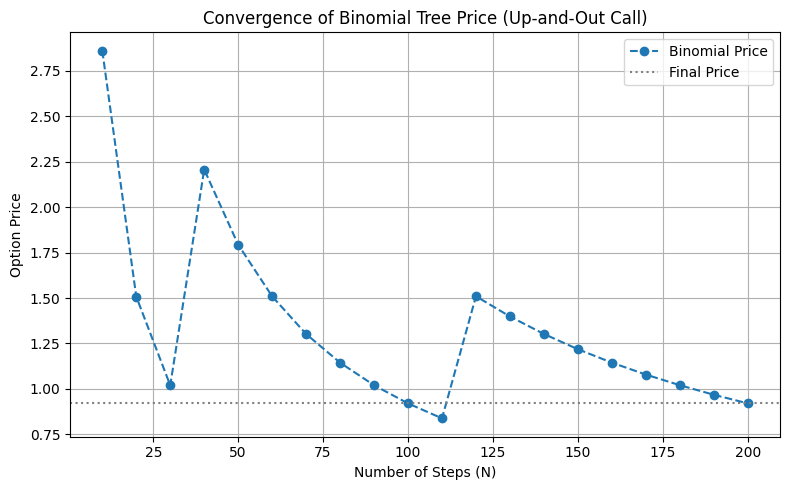

In [5]:
steps = np.arange(10, 201, 10)
prices = []

for N in steps:
    price = binomial_barrier_pricing(
        S0=100, K=100, T=1.0, r=0.05, sigma=0.2,
        N=N, barrier=110, option_type='call',
        barrier_type='up-and-out'
    )
    prices.append(price)

plt.figure(figsize=(8, 5))
plt.plot(steps, prices, marker='o', linestyle='--', label='Binomial Price')
plt.axhline(y=prices[-1], color='gray', linestyle=':', label='Final Price')
plt.title("Convergence of Binomial Tree Price (Up-and-Out Call)")
plt.xlabel("Number of Steps (N)")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Observations

- The binomial tree price for the up-and-out barrier call option gradually stabilizes as the number of steps increases.
- For barrier options, the convergence is slower than for vanilla options due to the path-dependency introduced by the barrier condition.
- A higher number of steps is required for reliable accuracy, especially when the barrier is close to the current asset price.